# __Diabetes prediction for the PIMA Indian Diabetes Database__
## Context
This dataset is originally from the National Institute of Diabetes and Digestive and Kidney Diseases. The objective of the dataset is to diagnostically predict whether or not a patient has diabetes, based on certain diagnostic measurements included in the dataset. Several constraints were placed on the selection of these instances from a larger database. In particular, all patients here are females at least 21 years old of Pima Indian heritage.

## Data Description
* _Pregnancies_ - Number of times pregnant    
* _Glucose_ - Plasma glucose concentration a 2 hours in an oral glucose tolerance test
* _Blood pressure_ - Diastolic blood pressure (mm Hg)
* _SkinThickness_ - Triceps skin fold thickness (mm)
* _Insulin_ - 2-Hour serum insulin (mu U/ml)
* _BMI_ - Body mass index (weight in kg/(height in m)^2)
* _DiabetesPedigreeFunction_ - Diabetes pedigree function
* _Age_ - Age (years)
* _Outcome_ - Class variable (0 or 1) 268 of 768 are 1, the others are 0

In [41]:
import pickle
from sklearn.model_selection import RepeatedStratifiedKFold, RandomizedSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, confusion_matrix, classification_report, f1_score
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('E:\JN\diabetes.csv')
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


# Basic EDA

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [4]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Pregnancies,768.0,3.845052,3.369578,0.000,1.00000,3.0000,6.00000,17.00
Glucose,768.0,120.894531,31.972618,0.000,99.00000,117.0000,140.25000,199.00
BloodPressure,768.0,69.105469,19.355807,0.000,62.00000,72.0000,80.00000,122.00
SkinThickness,768.0,20.536458,15.952218,0.000,0.00000,23.0000,32.00000,99.00
Insulin,768.0,79.799479,115.244002,0.000,0.00000,30.5000,127.25000,846.00
BMI,768.0,31.992578,7.884160,0.000,27.30000,32.0000,36.60000,67.10
DiabetesPedigreeFunction,768.0,0.471876,0.331329,0.078,0.24375,0.3725,0.62625,2.42
Age,768.0,33.240885,11.760232,21.000,24.00000,29.0000,41.00000,81.00
Outcome,768.0,0.348958,0.476951,0.000,0.00000,0.0000,1.00000,1.00


# Handling Missing Values

In this dataset missing data are filled with 0. First, we are gonna change zeros with NaN

In [5]:
df[['Glucose','BloodPressure','SkinThickness','Insulin','BMI']] = df[['Glucose','BloodPressure','SkinThickness',
                                                                      'Insulin','BMI']].replace(0, np.NaN)

In [6]:
df.isnull().sum()

Pregnancies                   0
Glucose                       5
BloodPressure                35
SkinThickness               227
Insulin                     374
BMI                          11
DiabetesPedigreeFunction      0
Age                           0
Outcome                       0
dtype: int64

# Filling the missing values with median values

In [7]:
def median_target(var):   
    temp = df[df[var].notnull()]
    temp = temp[[var, 'Outcome']].groupby(['Outcome'])[[var]].median().reset_index()
    return temp

In the above we are finding the median value the separate outcomes and then filling it in the missing values accordingly

In [8]:
cols = df.columns
cols = cols.drop('Outcome')

for col in cols:
    median_target(col)
    
    df.loc[(df['Outcome'] == 0) & (df[col].isnull()), col] = median_target(col)[col][0]
    df.loc[(df['Outcome'] == 1) & (df[col].isnull()), col] = median_target(col)[col][1]

In [9]:
df.isnull().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

Now as we can see all the missing values have been filled with their median values according to the target.

# Data visualisation

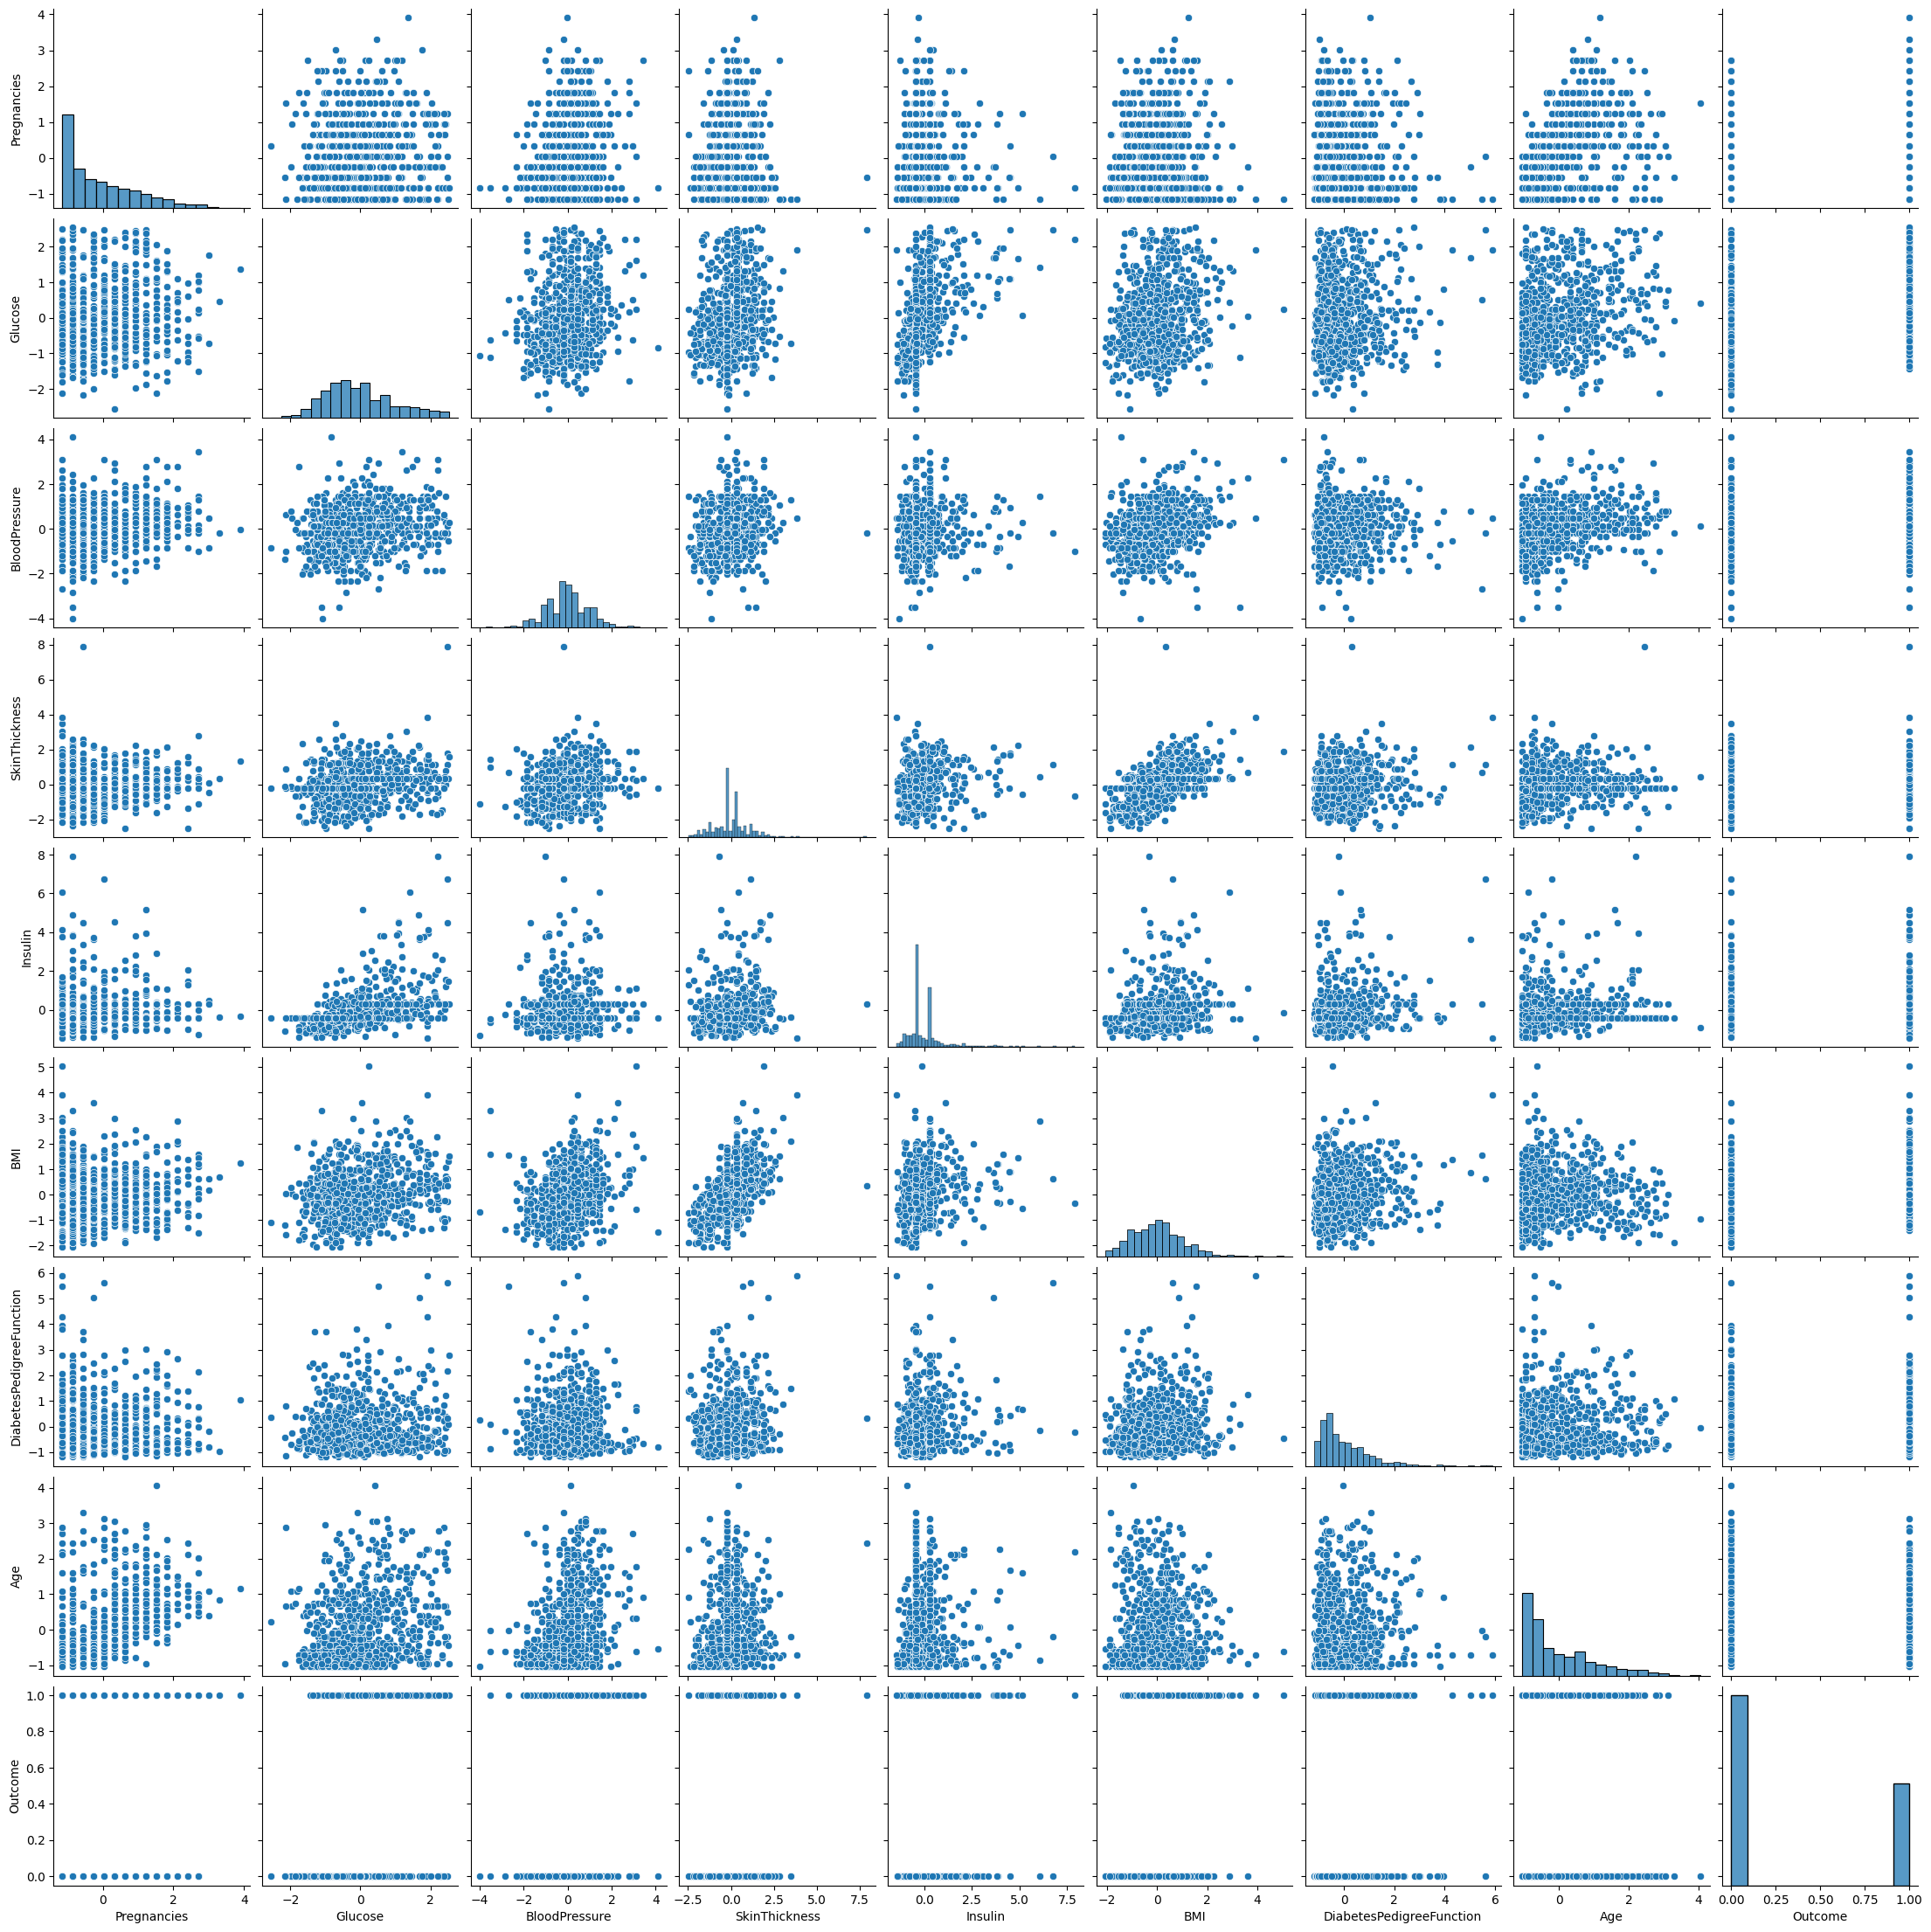

In [43]:
sns.pairplot(df)

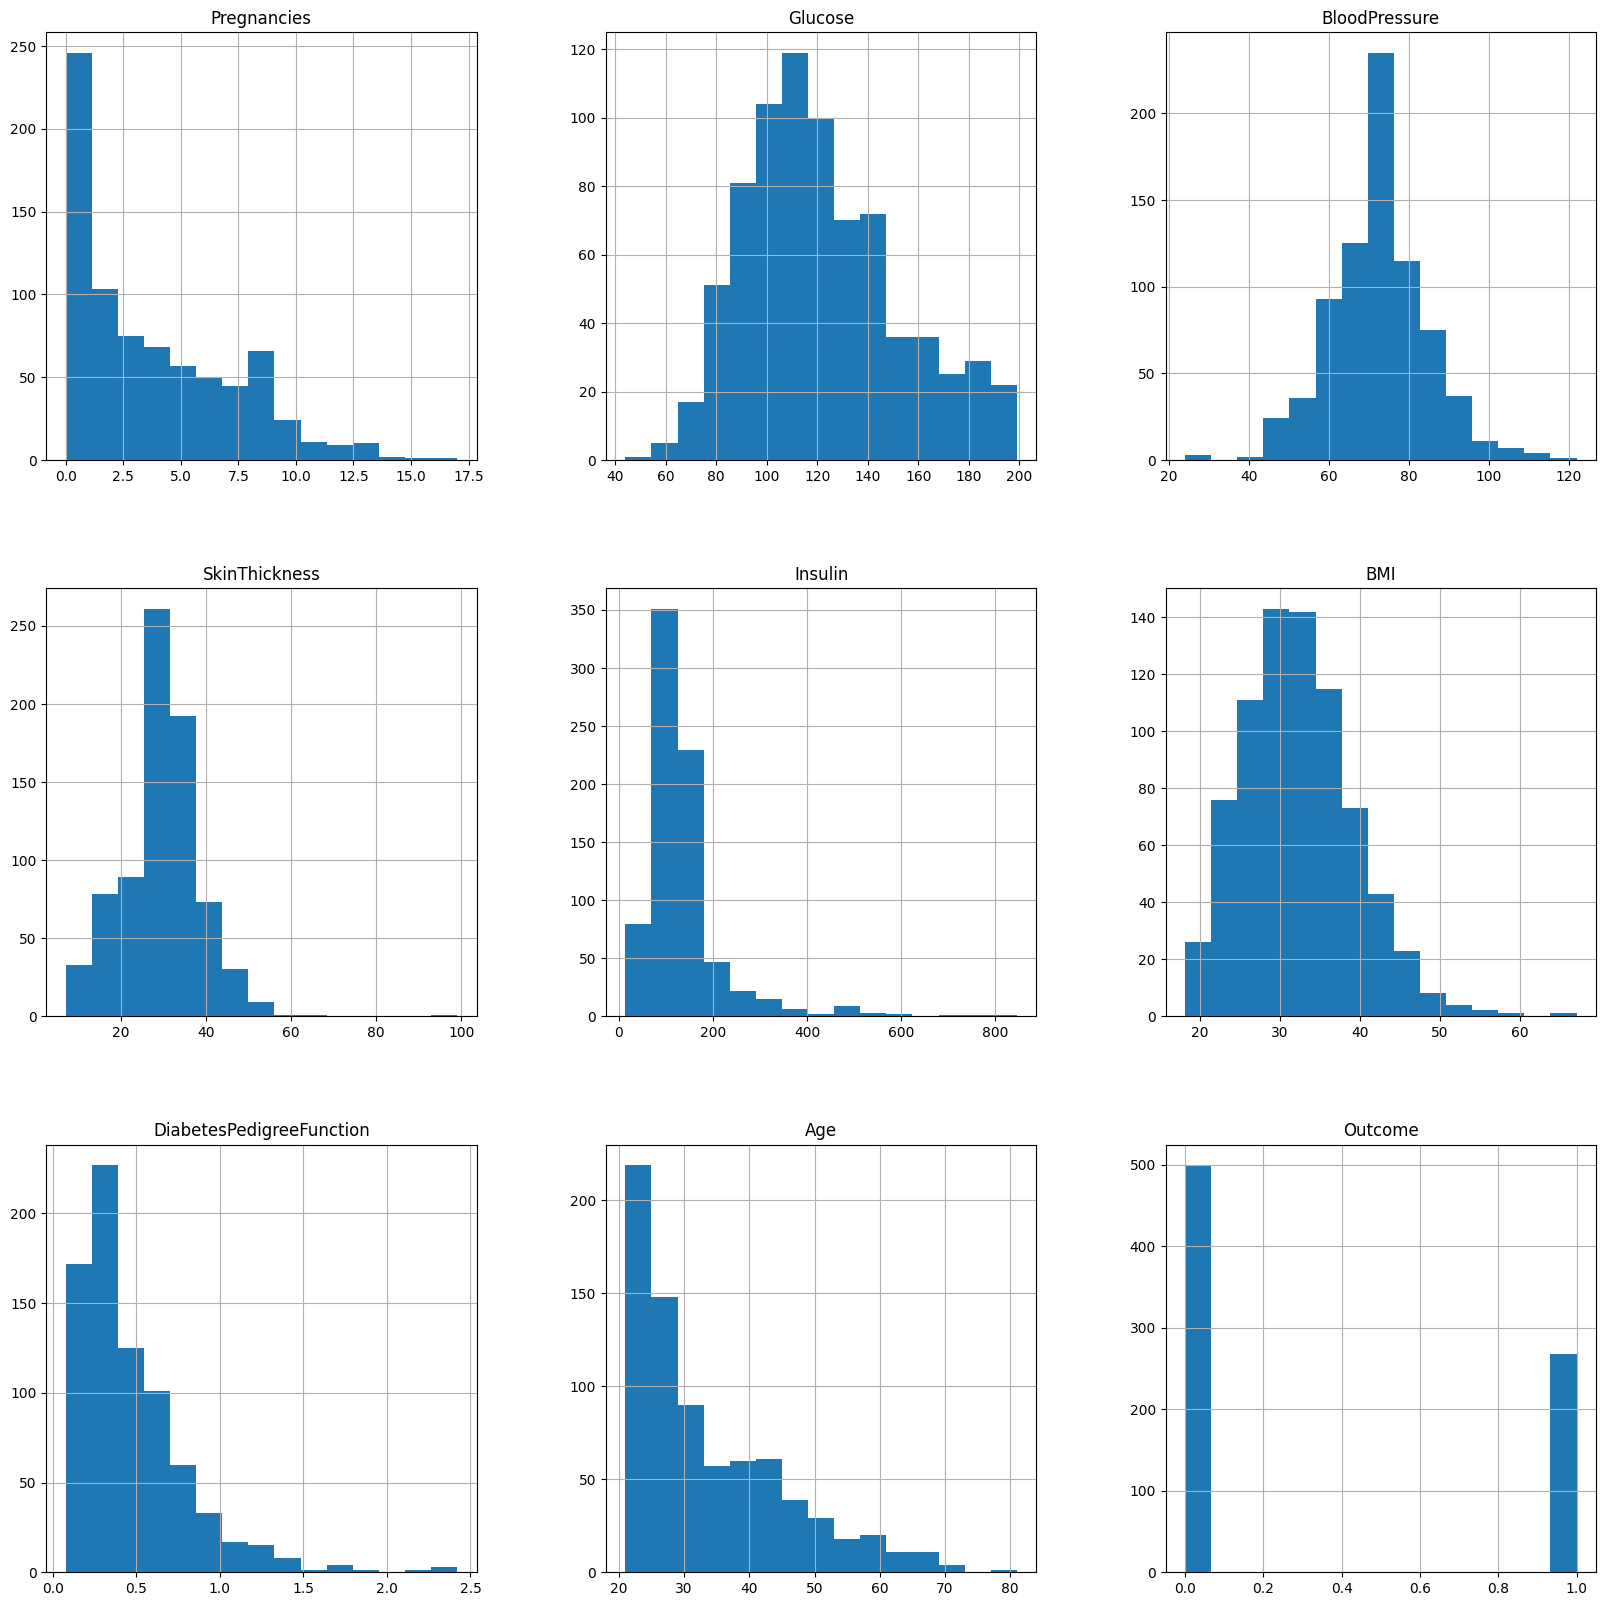

In [11]:
df.hist(bins=15,figsize=(20,20));

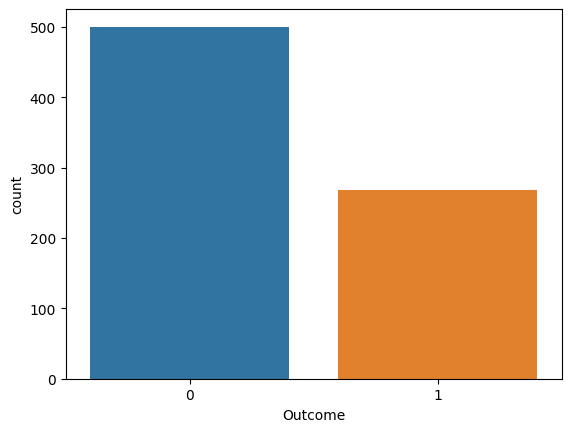

In [12]:
outcome = sns.countplot(x='Outcome',data=df,palette=["#1f77b4", "#ff7f0e"])

<Axes: >

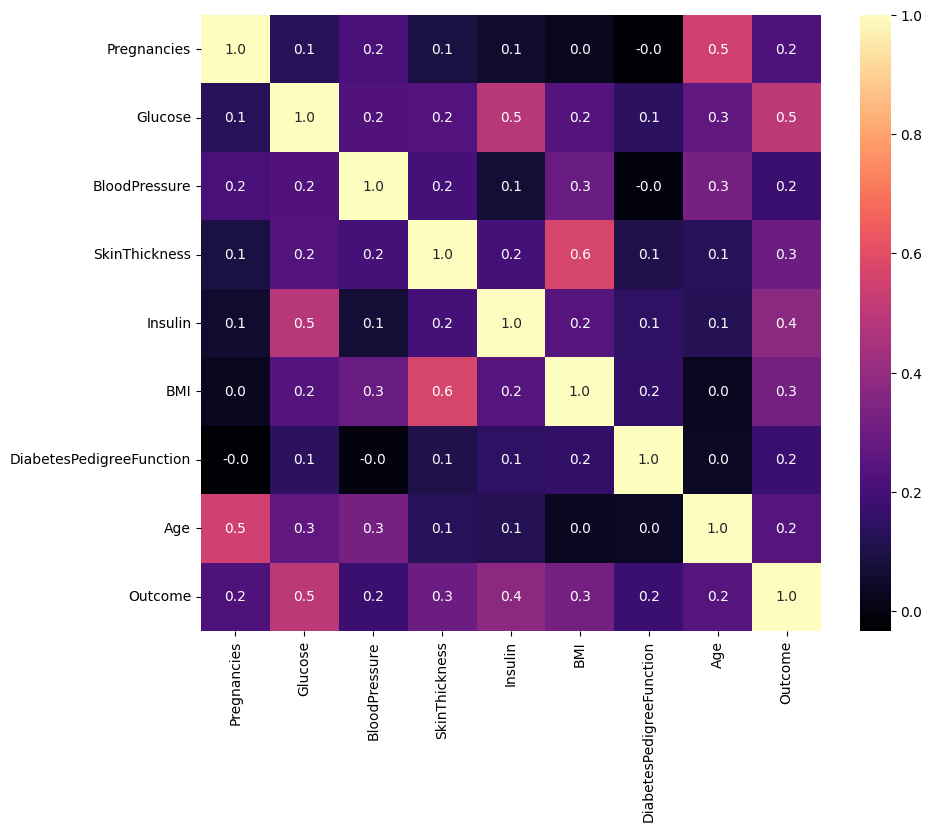

In [47]:
plt.figure(figsize=(10,8))
sns.heatmap(df.corr(),annot=True, fmt='0.1f',cmap='magma')

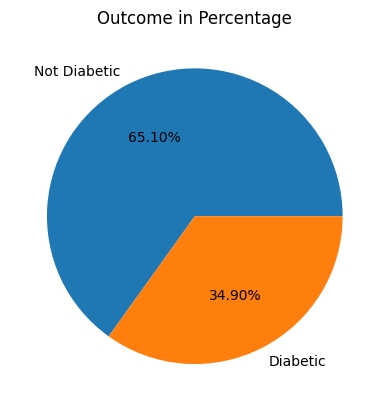

In [44]:
plt.title('Outcome in Percentage')
plt.pie(df['Outcome'].value_counts(),labels=['Not Diabetic','Diabetic'],autopct='%1.2f%%')
plt.show()

# Scaling the data

In [13]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
for col in df.columns[:-1]:
    df[col] = scaler.fit_transform(df[[col]])

In [14]:
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,0.639947,0.864625,-0.032180,0.665181,0.311604,0.169483,0.468492,1.425995,1
1,-0.844885,-1.204727,-0.528124,-0.010112,-0.440843,-0.848549,-0.365061,-0.190672,0
2,1.233880,2.014265,-0.693438,0.327535,0.311604,-1.328478,0.604397,-0.105584,1
3,-0.844885,-1.073339,-0.528124,-0.685405,-0.536303,-0.630399,-0.920763,-1.041549,0
4,-1.141852,0.503310,-2.677212,0.665181,0.294758,1.551096,5.484909,-0.020496,1


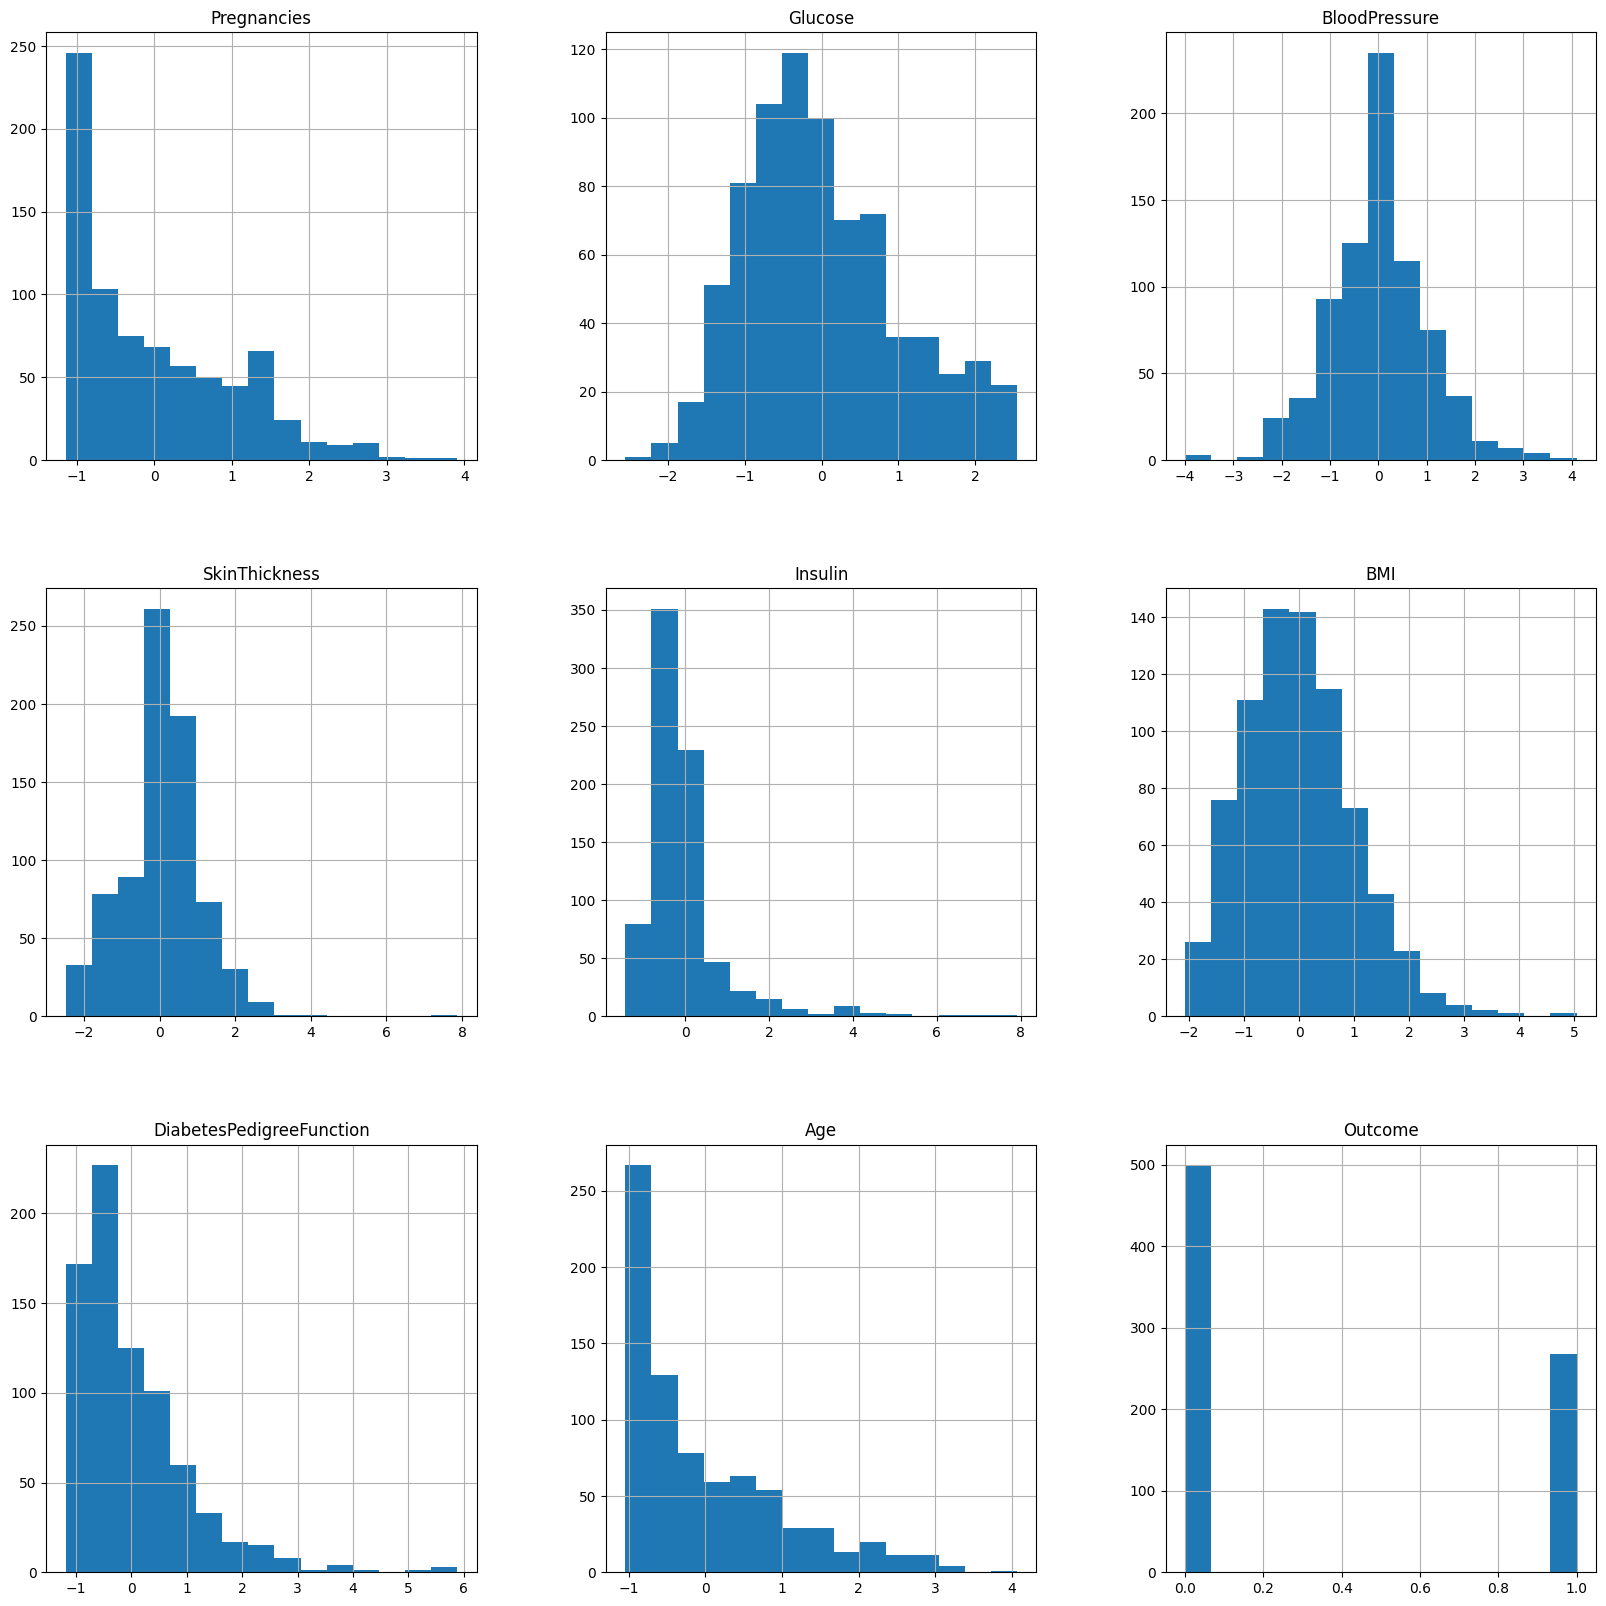

In [15]:
df.hist(bins=15,figsize=(20,20));

# Splitting data

In [16]:
from sklearn.model_selection import train_test_split
X = df.drop('Outcome',axis=1)
y = df['Outcome']

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,stratify=y,random_state=42)

In [17]:
def plt_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0,1],[0,1],"k--")
    plt.tight_layout()
    plt.axis([0,1,0,1])
    plt.legend()
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")

# Model Building

In [18]:
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier


model_rf = RandomForestClassifier(n_estimators=100)
model_ext = ExtraTreesClassifier()
model_ada = AdaBoostClassifier()
model_grad = GradientBoostingClassifier()
model_logis = LogisticRegression()
model_dec = DecisionTreeClassifier()

models = [model_rf, model_ext, model_ada, model_grad, model_logis, model_dec]

In [19]:
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, confusion_matrix, classification_report, f1_score

In [20]:
def model_train(model):
    model.fit(X_train,y_train)
    
    y_pred = model.predict(X_test)
    fpr, tpr, thresholds = roc_curve(y_test,y_pred)
    print(f'model: {model}')
    print(roc_auc_score(y_test, y_pred))
    print(classification_report(y_test,y_pred))
    plt_roc_curve(fpr,tpr,label=f'{model}')
    
    return f1_score(y_test,y_pred)

model: RandomForestClassifier()
0.8338888888888889
              precision    recall  f1-score   support

           0       0.88      0.89      0.89       100
           1       0.79      0.78      0.79        54

    accuracy                           0.85       154
   macro avg       0.84      0.83      0.84       154
weighted avg       0.85      0.85      0.85       154

model: ExtraTreesClassifier()
0.8338888888888889
              precision    recall  f1-score   support

           0       0.88      0.89      0.89       100
           1       0.79      0.78      0.79        54

    accuracy                           0.85       154
   macro avg       0.84      0.83      0.84       154
weighted avg       0.85      0.85      0.85       154

model: AdaBoostClassifier()
0.8346296296296297
              precision    recall  f1-score   support

           0       0.88      0.91      0.89       100
           1       0.82      0.76      0.79        54

    accuracy                       

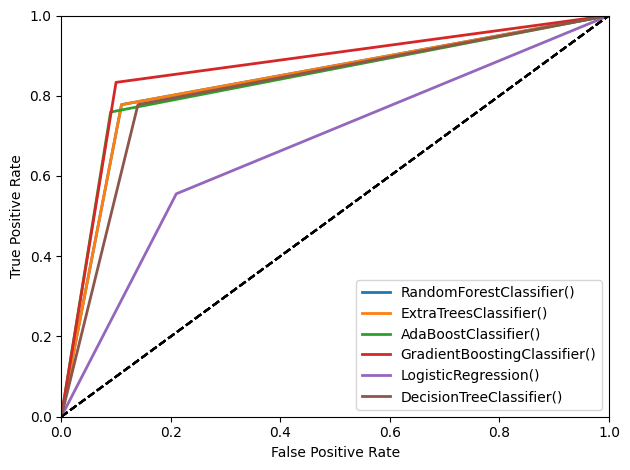

In [21]:
scores = {'Random Forest':0,
          'ExtraTress': 0,
          'AdaBoost':0,
          'Gradient Boosting':0,
          'Logistic Regression':0,
          'Decision Tree':0}


scr = []
for i,model in enumerate(models):
    score = model_train(model)
    scr.append(score)

From the above we can see that Gradient Boosting algorithm is performing well

Without any feature engineering we got higher ROC

## K-Fold cross validated models with RandomSearchCV for best params

In [22]:
from sklearn.model_selection import RepeatedStratifiedKFold, RandomizedSearchCV
from sklearn.pipeline import make_pipeline

In [23]:
def ml_model(model, parameters):
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=10, random_state=1)
    random_search = RandomizedSearchCV(model, parameters, cv=cv, random_state=1, n_jobs=-1, verbose=2 )
    #pipe = make_pipeline(StandardScaler(),random_search)
    random_search.fit(X_train, y_train)
    y_pred_proba = random_search.predict_proba(X_test)[:,1]
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
    print("ROC Score : ",roc_auc_score(y_test, y_pred_proba))
    print("Accuracy for train: ", accuracy_score(y_train, random_search.predict(X_train)))
    print("Accuracy for test: " , accuracy_score(y_test, random_search.predict(X_test)))
    print("Best params:" + str(random_search.best_params_))
    plt_roc_curve(fpr,tpr,label='Model')
    
    return random_search
    
log_reg_params = {"C" : [1,2,3,0.01,0.001, 2.5, 1.5],
                  "max_iter" : range(100,800,100)}
knn_params = {"n_neighbors" : np.arange(1,50),
              "leaf_size" : np.arange(1,50)}
decTree_params = {"max_depth" : [5,10,15,20,25,30],
                  "min_samples_split" : np.arange(2,50),
                  "min_samples_leaf" : np.arange(1,50)}
randomForest_params = {"n_estimators" : [100,500, 1000],
                       "min_samples_split" : np.arange(2,30),
                       "min_samples_leaf" : np.arange(1,50),
                       "max_features" : np.arange(1,7)}
grad_params = {"n_estimators" : [100,500,1000],
               "subsample" : [0.6,0.8,1.0],
               "max_depth" : [5,10,15,20,25,30],
               "learning_rate" : [0.1, 0.01, 0.02, 0.5]
               }

sgd_params = {"alpha" : [0.0001, 0.1, 0.001, 0.01],
              "max_iter" : [100,500,1000,2000],
              "loss" : ["log","modified_huber","perceptron"]}

Fitting 100 folds for each of 10 candidates, totalling 1000 fits
ROC Score :  0.8262962962962963
Accuracy for train:  0.7947882736156352
Accuracy for test:  0.7077922077922078
Best params:{'max_iter': 700, 'C': 1.5}


RandomizedSearchCV(cv=RepeatedStratifiedKFold(n_repeats=10, n_splits=10, random_state=1),
                   estimator=LogisticRegression(), n_jobs=-1,
                   param_distributions={'C': [1, 2, 3, 0.01, 0.001, 2.5, 1.5],
                                        'max_iter': range(100, 800, 100)},
                   random_state=1, verbose=2)

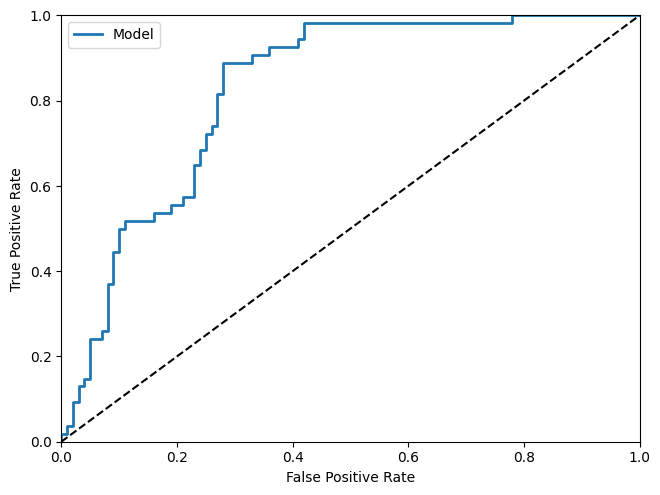

In [24]:
ml_model(LogisticRegression(), log_reg_params)

Fitting 100 folds for each of 10 candidates, totalling 1000 fits
ROC Score :  0.8527777777777779
Accuracy for train:  0.8452768729641694
Accuracy for test:  0.7857142857142857
Best params:{'n_neighbors': 19, 'leaf_size': 23}


RandomizedSearchCV(cv=RepeatedStratifiedKFold(n_repeats=10, n_splits=10, random_state=1),
                   estimator=KNeighborsClassifier(), n_jobs=-1,
                   param_distributions={'leaf_size': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49]),
                                        'n_neighbors': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49])},
                   random_state=1, verbose=2)

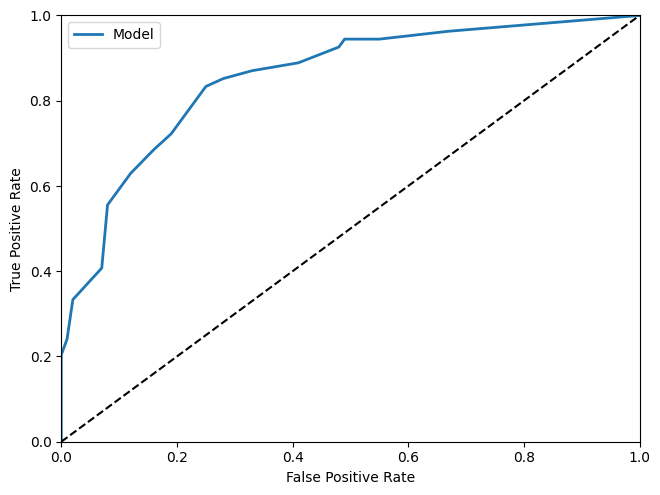

In [25]:
ml_model(KNeighborsClassifier(), knn_params)

Fitting 100 folds for each of 10 candidates, totalling 1000 fits
ROC Score :  0.9088888888888889
Accuracy for train:  0.9185667752442996
Accuracy for test:  0.8766233766233766
Best params:{'min_samples_split': 18, 'min_samples_leaf': 8, 'max_depth': 15}


RandomizedSearchCV(cv=RepeatedStratifiedKFold(n_repeats=10, n_splits=10, random_state=1),
                   estimator=DecisionTreeClassifier(), n_jobs=-1,
                   param_distributions={'max_depth': [5, 10, 15, 20, 25, 30],
                                        'min_samples_leaf': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49]),
                                        'min_samples_split': array([ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
       19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35,
       36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49])},
                   random_state=1, verbose=2)

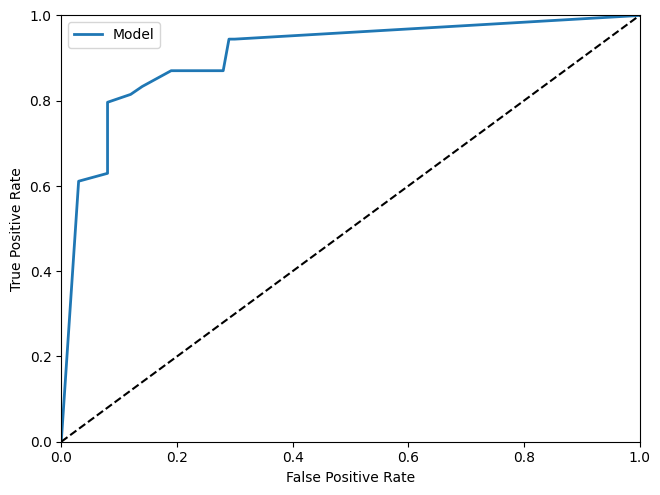

In [26]:
ml_model(DecisionTreeClassifier(), decTree_params)

Fitting 100 folds for each of 10 candidates, totalling 1000 fits
ROC Score :  0.9496296296296296
Accuracy for train:  0.9674267100977199
Accuracy for test:  0.8831168831168831
Best params:{'n_estimators': 1000, 'min_samples_split': 11, 'min_samples_leaf': 1, 'max_features': 6}


RandomizedSearchCV(cv=RepeatedStratifiedKFold(n_repeats=10, n_splits=10, random_state=1),
                   estimator=RandomForestClassifier(), n_jobs=-1,
                   param_distributions={'max_features': array([1, 2, 3, 4, 5, 6]),
                                        'min_samples_leaf': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49]),
                                        'min_samples_split': array([ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
       19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]),
                                        'n_estimators': [100, 500, 1000]},
                   random_state=1, verbose=2)

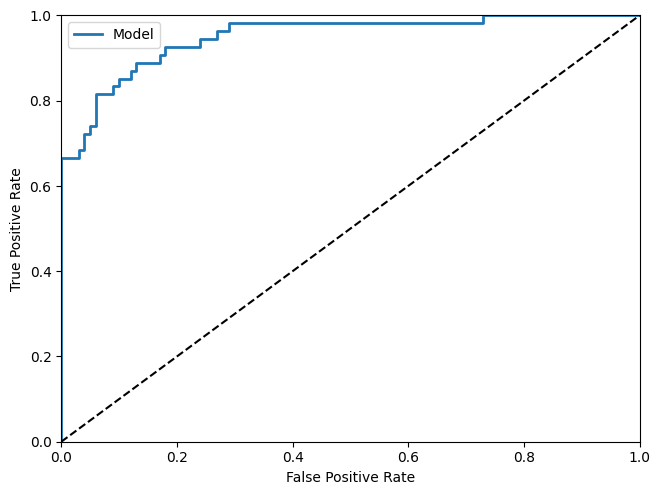

In [27]:
ml_model(RandomForestClassifier(), randomForest_params)

Fitting 100 folds for each of 10 candidates, totalling 1000 fits
ROC Score :  0.8057407407407406
Accuracy for train:  0.7947882736156352
Accuracy for test:  0.7402597402597403
Best params:{'max_iter': 2000, 'loss': 'modified_huber', 'alpha': 0.001}


RandomizedSearchCV(cv=RepeatedStratifiedKFold(n_repeats=10, n_splits=10, random_state=1),
                   estimator=SGDClassifier(), n_jobs=-1,
                   param_distributions={'alpha': [0.0001, 0.1, 0.001, 0.01],
                                        'loss': ['log', 'modified_huber',
                                                 'perceptron'],
                                        'max_iter': [100, 500, 1000, 2000]},
                   random_state=1, verbose=2)

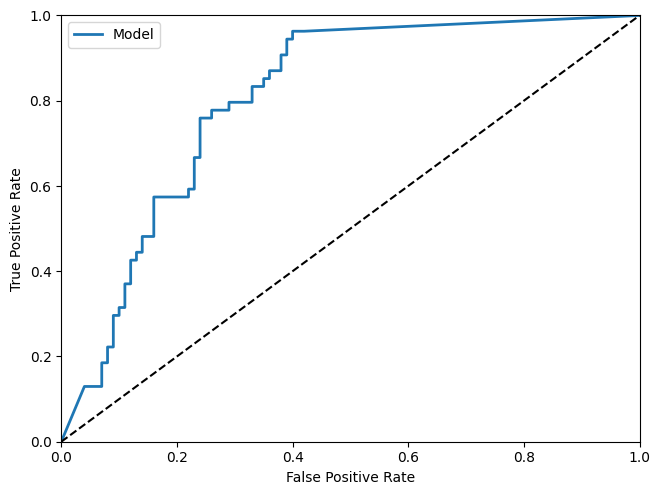

In [28]:
ml_model(SGDClassifier(), sgd_params)

Fitting 100 folds for each of 10 candidates, totalling 1000 fits
ROC Score :  0.9564814814814815
Accuracy for train:  1.0
Accuracy for test:  0.8831168831168831
Best params:{'subsample': 0.6, 'n_estimators': 500, 'max_depth': 20, 'learning_rate': 0.01}


RandomizedSearchCV(cv=RepeatedStratifiedKFold(n_repeats=10, n_splits=10, random_state=1),
                   estimator=GradientBoostingClassifier(), n_jobs=-1,
                   param_distributions={'learning_rate': [0.1, 0.01, 0.02, 0.5],
                                        'max_depth': [5, 10, 15, 20, 25, 30],
                                        'n_estimators': [100, 500, 1000],
                                        'subsample': [0.6, 0.8, 1.0]},
                   random_state=1, verbose=2)

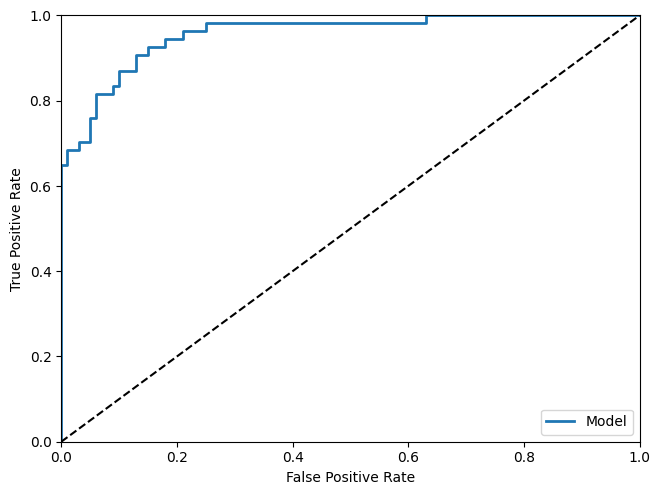

In [29]:
ml_model(GradientBoostingClassifier(), grad_params)

__We got highest roc_score of 95% for the Random Forest model with the following parameters Hence we are storing the model with that best params and we are going to use that for the prediction__

Gradient Boosting seems to overfit the training data hence we are using the RandomForest model

In [30]:
model_final_random = RandomForestClassifier(n_estimators = 1000,
                                            min_samples_split = 8, 
                                            min_samples_leaf = 11, 
                                            max_features = 6)

In [31]:
model_final_random.fit(X_train, y_train)

RandomForestClassifier(max_features=6, min_samples_leaf=11, min_samples_split=8,
                       n_estimators=1000)

ROC Score :  0.9462962962962963
Accuracy for train:  0.9185667752442996
Accuracy for test:  0.8701298701298701


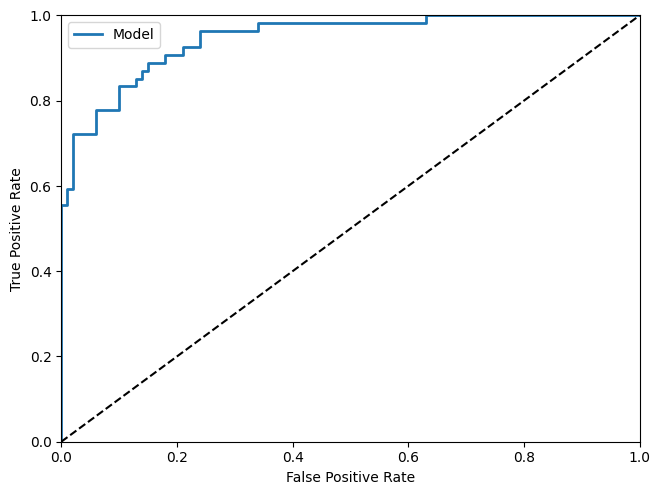

In [33]:
y_pred_proba = model_final_random.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
print("ROC Score : ",roc_auc_score(y_test, y_pred_proba))
print("Accuracy for train: ", accuracy_score(y_train, model_final_random.predict(X_train)))
print("Accuracy for test: " , accuracy_score(y_test, model_final_random.predict(X_test)))
plt_roc_curve(fpr,tpr,label='Model')

In [34]:
y_pred = model_final_random.predict(X_test)

<Axes: >

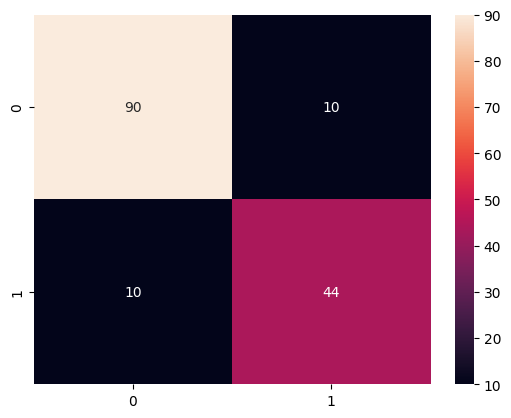

In [35]:
sns.heatmap(confusion_matrix(y_test,y_pred),annot=True)

__Storing the Best Model__

In [36]:
import pickle

with open('model_rf.pkl','wb') as file:
    pickle.dump(model_final_random,file)

#### We have successfully stored our model in our storage